In [68]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
try:
    import plotly.graph_objects as go
    import plotly.offline as pyo
    pyo.init_notebook_mode(connected=True)
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("plotlyがインストールされていません。'pip install plotly'でインストールしてください。")

from nets import *
from cfgs import *
from data import *
from trainer import *
from payment_utils import get_payment

In [69]:
%matplotlib inline
save_plot = False
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
D = 201

x = np.linspace(0, 4.0, D)
X_tst = np.stack([v.flatten() for v in np.meshgrid(x,x)], axis = -1)
print(X_tst.shape)

cfg = additive_1x2_gamma_1_6_config.cfg
cfg.test.batch_size = D
cfg.test.num_batches = int(X_tst.shape[0]/cfg.test.batch_size)
cfg.test.save_output = True

(40401, 2)


In [70]:
Net = additive_net.Net
Generator = gamma_1_6_generator.Generator
Trainer = trainer.Trainer

In [71]:
net = Net(cfg, "test")
generator = Generator(cfg, 'test', X_tst)
m = Trainer(cfg, "test", net)
m.test(generator)

2025-11-13 11:24:20,319:INFO:TEST ALL-400000: t = 0.8890, Net_Loss: -1.964895, Revenue: 1.964895
2025-11-13 11:24:20,319:INFO:TEST ALL-400000: t = 0.8890, Net_Loss: -1.964895, Revenue: 1.964895
2025-11-13 11:24:20,319:INFO:TEST ALL-400000: t = 0.8890, Net_Loss: -1.964895, Revenue: 1.964895
2025-11-13 11:24:20,319:INFO:TEST ALL-400000: t = 0.8890, Net_Loss: -1.964895, Revenue: 1.964895
2025-11-13 11:24:20,319:INFO:TEST ALL-400000: t = 0.8890, Net_Loss: -1.964895, Revenue: 1.964895


In [72]:
alloc = np.load(os.path.join(cfg.dir_name, "alloc_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D,D,2)
pay = np.load(os.path.join(cfg.dir_name, "pay_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D,D)

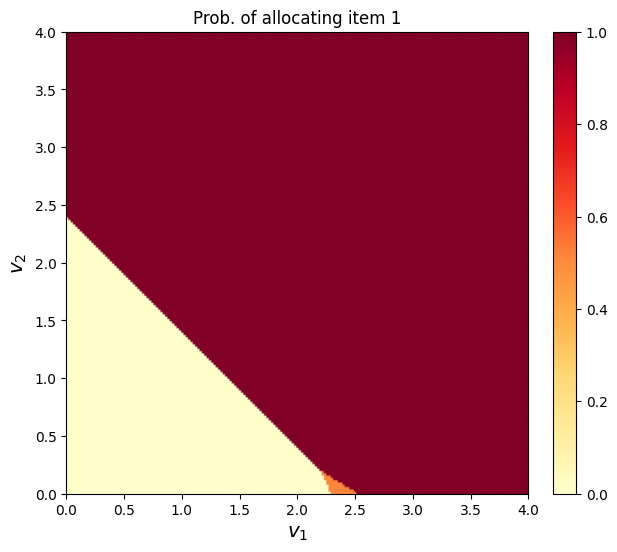

In [73]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))

img = ax.imshow(alloc[::-1, :, 0], extent=[0,4,0,4], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd')
                    
ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title('Prob. of allocating item 1')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc1.pdf'), bbox_inches = 'tight', pad_inches = 0.05)

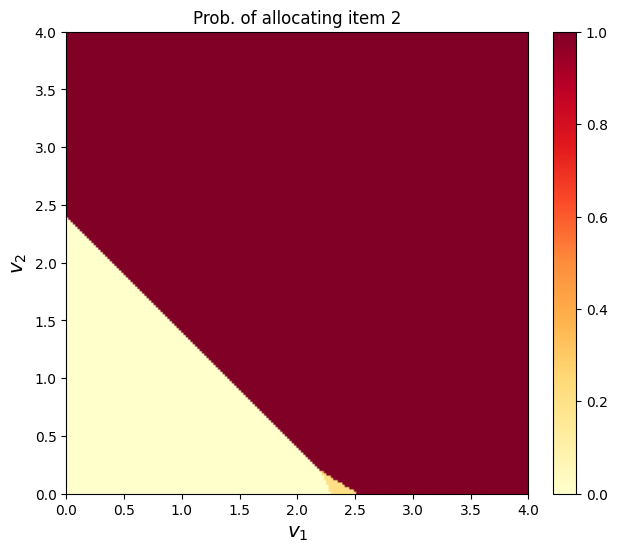

In [74]:
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))

img = ax.imshow(alloc[::-1, :, 1], extent=[0,4,0,4], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd')
              
ax.set_xlabel(r'$v_1$')
ax.set_ylabel(r'$v_2$')
plt.title('Prob. of allocating item 2')
_ = plt.colorbar(img, fraction=0.046, pad=0.04)

if save_plot:
    fig.set_size_inches(4, 3)
    plt.savefig(os.path.join(cfg.dir_name, 'alloc2.pdf'), bbox_inches = 'tight', pad_inches = 0.05)

In [77]:
# インタラクティブなプロット（plotly使用）- マウスホバーで座標と値を表示
if PLOTLY_AVAILABLE:
    try:
        # データを準備（plotlyではy軸を反転するので、データ自体は反転しない）
        # matplotlibのimshowでは[::-1, :]で反転するが、plotlyではyaxis=dict(autorange='reversed')で反転する
        pay_display = pay  # データは反転しない
        x_coords = np.linspace(0, 4.0, D)
        y_coords = np.linspace(0, 4.0, D)
        
        # plotlyのヒートマップを作成
        fig = go.Figure(data=go.Heatmap(
            z=pay_display,
            x=x_coords,
            y=y_coords,
            colorscale='YlOrRd',
            colorbar=dict(title="Payment"),
            hovertemplate='v₁=%{x:.3f}<br>v₂=%{y:.3f}<br>Payment=%{z:.6f}<extra></extra>',
            name=''
        ))
        
        fig.update_layout(
            title='Payment (Interactive - Hover to see values)',
            xaxis_title='v₁',
            yaxis_title='v₂',
            width=800,
            height=600
        )
        
        # HTMLファイルとして保存して表示（最も確実な方法）
        html_file = os.path.join(cfg.dir_name, 'pay_interactive.html')
        fig.write_html(html_file)
        print(f"インタラクティブなプロットを保存しました: {html_file}")
        print("ブラウザで開くと、マウスホバーで座標と値を表示できます。")
        
        # Jupyter Notebook内で表示を試みる
        try:
            from IPython.display import HTML, IFrame
            display(HTML(f'<iframe src="{html_file}" width="850" height="650"></iframe>'))
        except:
            try:
                from IPython.display import display, HTML
                display(HTML(f'<a href="{html_file}" target="_blank">インタラクティブなプロットを開く</a>'))
            except:
                pass
        
        if save_plot:
            try:
                fig.write_image(os.path.join(cfg.dir_name, 'pay.pdf'))
            except:
                pass  # write_imageが使えない場合はスキップ
    except Exception as e:
        print(f"plotlyの表示でエラーが発生しました: {e}")
        print("matplotlibのプロットにフォールバックします。")
        PLOTLY_AVAILABLE = False

if not PLOTLY_AVAILABLE:
    # plotlyが利用できない場合はmatplotlibを使用
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8,6))
    
    # データを反転して表示（[::-1, :]の効果を考慮）
    pay_display = pay[::-1, :]
    
    img = ax.imshow(pay_display, extent=[0,4,0,4], cmap = 'YlOrRd')
                  
    ax.set_xlabel(r'$v_1$')
    ax.set_ylabel(r'$v_2$')
    plt.title('Payment')
    _ = plt.colorbar(img, fraction=0.046, pad=0.04)
    
    if save_plot:
        fig.set_size_inches(4, 3)
        plt.savefig(os.path.join(cfg.dir_name, 'pay.pdf'), bbox_inches = 'tight', pad_inches = 0.05)


インタラクティブなプロットを保存しました: experiments/additive_1x2_gamma_1_6/pay_interactive.html
ブラウザで開くと、マウスホバーで座標と値を表示できます。


In [65]:
# 使用例
idx1, idx2, actual_v1, actual_v2, payment_val = get_payment(x, pay, 0.1, 2.3)
print(f"v1={actual_v1:.4f}, v2={actual_v2:.4f}: payment={payment_val:.6f}")

v1=0.1000, v2=2.3000: payment=1.177200
